In [40]:
#pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

df = pd.read_csv('df_combine.csv', parse_dates=['date'])

# 設置日期列為索引
df.set_index('date', inplace=True)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device:{device}")

device:cpu


In [42]:
#移除object的欄位
df_dtypes = pd.DataFrame(df.dtypes)
df_dtypes.reset_index(drop=False,inplace=True)
df_dtypes.rename(columns={"index":"colnames",0:"type"},inplace=True)
col_select = list(df_dtypes.loc[df_dtypes["type"]!="object","colnames"])
df = df[col_select] 

In [43]:
# 計算相關係數矩陣
corr_matrix = df.corr()

# 以相關係數矩陣(相關性大於0.5)所選擇出之特徵
selected_features = corr_matrix.index[corr_matrix['close_after_90'].abs() > 0.5].tolist()
selected_features.remove('close')
print(selected_features)

In [50]:
# randomfroest所選擇之特徵
df = df.dropna()
selected_features = ['open', 'high', 'low', 'volume', 'vwap', 'sma_5', 'sma_20',
    'inventoryGrowth',
    'dividendsperShareGrowth',
    'rdexpenseGrowth',
    'priceToSalesRatio',
    'adjClose',
    'threeYNetIncomeGrowthPerShare',
    'priceSalesRatio',
    'growthResearchAndDevelopmentExpenses',
    'receivablesTurnover',
    'standardDeviation_252',
    'growthTotalLiabilities',
    'fiveYRevenueGrowthPerShare',
    'growthTotalDebt',
    'rsi_60',
    'debtGrowth']

In [51]:
# 準備特徵以及目標 X為特徵變數矩陣 y為我們的目標(股價)
X = df[selected_features]
# 標準化解釋變數
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 設定目標變數
y = df['close']

# 使用前面的數據訓練模型，並預測最後90天的數據
train_size = len(y) - 90
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 將數據轉換為 PyTorch 張量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [54]:
# 定義 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# 定義模型參數
input_size = X_train_tensor.shape[1]
hidden_size = 50
output_size = 1
num_layers = 1

# 創建模型實例
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 300
batch_size = 16

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/300], Loss: 1010.7733
Epoch [20/300], Loss: 429.4857
Epoch [30/300], Loss: 116.6206
Epoch [40/300], Loss: 37.1827
Epoch [50/300], Loss: 16.9224
Epoch [60/300], Loss: 7.8994
Epoch [70/300], Loss: 3.7536
Epoch [80/300], Loss: 1.7569
Epoch [90/300], Loss: 1.8285
Epoch [100/300], Loss: 0.2434
Epoch [110/300], Loss: 0.1907
Epoch [120/300], Loss: 0.0749
Epoch [130/300], Loss: 0.9017
Epoch [140/300], Loss: 0.0381
Epoch [150/300], Loss: 0.0858
Epoch [160/300], Loss: 0.1920
Epoch [170/300], Loss: 0.3783
Epoch [180/300], Loss: 0.0333
Epoch [190/300], Loss: 0.1305
Epoch [200/300], Loss: 0.0327
Epoch [210/300], Loss: 0.0136
Epoch [220/300], Loss: 0.0263
Epoch [230/300], Loss: 0.0595
Epoch [240/300], Loss: 0.0044
Epoch [250/300], Loss: 0.0078
Epoch [260/300], Loss: 0.0162
Epoch [270/300], Loss: 0.0121
Epoch [280/300], Loss: 0.0203
Epoch [290/300], Loss: 0.0122
Epoch [300/300], Loss: 0.0135


Test MSE: 2.1037


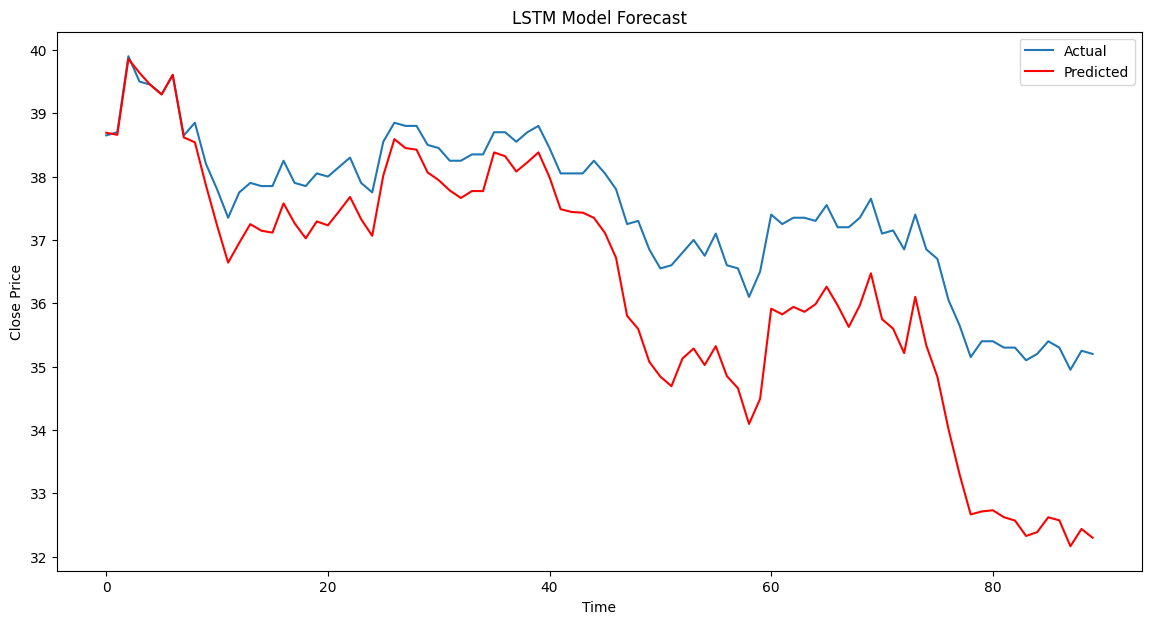

In [56]:
# 評估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.unsqueeze(1))
    mse = criterion(y_pred, y_test_tensor)
    print(f'Test MSE: {mse.item():.4f}')

# 視覺化預測結果
plt.figure(figsize=(14, 7))
plt.plot(y_test_tensor.numpy(), label='Actual')
plt.plot(y_pred.numpy(), label='Predicted', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('LSTM Model Forecast')
plt.show()
